In [159]:
%load_ext autoreload
%autoreload 2

In [303]:
import gpxpy
import ggps
import haversine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [304]:
from gps_analysis import sphere, files, splits

In [484]:
positions = files.load_gpx("activity_768041870.gpx")
locations = pd.read_json('cam_locations.json', orient='index')
positions

,latitude,longitude,time,timeElapsed,distanceDelta,distance,bearing_r,bearing
0,52.211003,0.130434,2015-05-07 17:17:16+00:00,0 days 00:00:00,0.000000,0.000000,-2.947566,-168.883087
1,52.211131,0.130475,2015-05-07 17:18:48+00:00,0 days 00:01:32,0.014514,0.014514,-2.947566,-168.883087
2,52.211091,0.130508,2015-05-07 17:19:05+00:00,0 days 00:01:49,0.005001,0.019515,-0.475673,-27.254082
3,52.211024,0.130640,2015-05-07 17:19:12+00:00,0 days 00:01:56,0.011685,0.031200,-0.877730,-50.290213
4,52.210954,0.130768,2015-05-07 17:19:17+00:00,0 days 00:02:01,0.011636,0.042836,-0.845724,-48.456416
...,...,...,...,...,...,...,...,...
563,52.210635,0.131943,2015-05-07 18:21:05+00:00,0 days 01:03:49,0.020048,9.365145,1.865600,106.891014
564,52.210705,0.131614,2015-05-07 18:21:11+00:00,0 days 01:03:55,0.023716,9.388861,1.902649,109.013765
565,52.210758,0.131396,2015-05-07 18:21:15+00:00,0 days 01:03:59,0.016004,9.404865,1.952104,111.847345
566,52.210850,0.131081,2015-05-07 18:21:21+00:00,0 days 01:04:05,0.023780,9.428645,2.016539,115.539184


In [536]:
loc_times = {
    loc: sphere.find_crossing_times(positions, pos)
    for loc, pos in locations.iterrows()
}
loc_times

{'outflow': 240   2015-05-07 17:41:37.683686942+00:00
 331   2015-05-07 17:59:05.496169810+00:00
 dtype: datetime64[ns, SimpleTZ("Z")],
 'headstation': 228   2015-05-07 17:40:34.766991264+00:00
 344   2015-05-07 18:00:15.261656924+00:00
 dtype: datetime64[ns, SimpleTZ("Z")],
 'entry_firstpost': 221   2015-05-07 17:39:56.320649027+00:00
 350   2015-05-07 18:00:45.450465533+00:00
 dtype: datetime64[ns, SimpleTZ("Z")],
 'exit_firstpost': 212   2015-05-07 17:39:13.612220616+00:00
 361   2015-05-07 18:01:43.888163262+00:00
 dtype: datetime64[ns, SimpleTZ("Z")],
 'entry_grassy': 204   2015-05-07 17:38:28.997228765+00:00
 371   2015-05-07 18:02:47.508992825+00:00
 dtype: datetime64[ns, SimpleTZ("Z")],
 'exit_grassy': 197   2015-05-07 17:37:51.152127930+00:00
 379   2015-05-07 18:03:17.139750910+00:00
 dtype: datetime64[ns, SimpleTZ("Z")],
 'plough': 187   2015-05-07 17:36:52.360354060+00:00
 391   2015-05-07 18:04:20.459573764+00:00
 dtype: datetime64[ns, SimpleTZ("Z")],
 'entry_ditton': 186 

In [335]:
i, j = np.triu_indices(len(positions), 1)
i, j

time_diffs = (
    positions.timeElapsed[j].dt.total_seconds().values - 
    positions.timeElapsed[i].dt.total_seconds().values)
time_diffs
dist_diffs =(
    positions.distance[j].values - 
    positions.distance[i].values)
time_diffs
speeds = 1000 * np.nan_to_num(dist_diffs / time_diffs)

/tmp/ipykernel_654/1754248165.py:12: RuntimeWarning: invalid value encountered in true_divide
  speeds = 1000 * np.nan_to_num(dist_diffs / time_diffs)


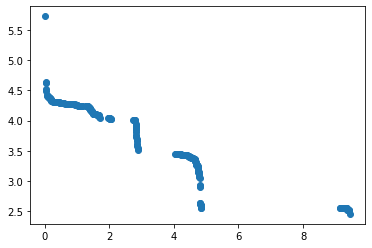

In [338]:
mask = is_pareto_efficient(np.c_[-dist_diffs, -speeds])

plt.scatter(
    dist_diffs[mask],
    speeds[mask]
)

In [307]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

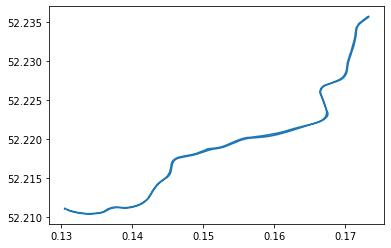

In [286]:
plt.plot(positions.longitude, positions.latitude)